In [9]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, GroupKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, f1_score, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Import Data
data = pd.read_csv("data/online_retail_II.csv")

In [11]:
# STEP 1: Data Loading & Preparation

# 1. Basic Cleaning
data = data.drop_duplicates()
data = data[data['Price'] > 0]
data = data.dropna(subset=['Customer ID'])
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# 2. Create NetRevenue
# Identify returns (Invoices starting with 'C')
data['IsReturn'] = data['Invoice'].astype(str).str.startswith('C')
# Calculate purchase amount (positive) and return amount (absolute value)
data['PurchaseAmount'] = np.where(data['IsReturn'] == False, data['Quantity'] * data['Price'], 0)
data['ReturnAmount'] = np.where(data['IsReturn'] == True,  (data['Quantity'] * data['Price']).abs(), 0)
# Define NetRevenue
data['NetRevenue'] = data['PurchaseAmount'] - data['ReturnAmount']

print(f"Data Prepared. Rows: {len(data)}")
print(f"Columns: {data.columns.tolist()}")

Data Prepared. Rows: 797815
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'IsReturn', 'PurchaseAmount', 'ReturnAmount', 'NetRevenue']


In [26]:
# STEP 2: FEATURE ENGINEERING & DATA GENERATION (FIXED COMPARISON)

def generate_features_at_cutoff(df_input, cutoff_date, target_window_days=180):
    
    # Use pre-cleaned data (NetRevenue must exist)
    df = df_input.copy()
    
    # Define history and future windows
    history = df[df['InvoiceDate'] <= cutoff_date].copy()
    future = df[(df['InvoiceDate'] > cutoff_date) & (df['InvoiceDate'] <= cutoff_date + pd.Timedelta(days=180))]
    
    snapshot_date = cutoff_date + pd.Timedelta(days=1)
    
    # 2. Base RFM Features
    features = history.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'Invoice': 'nunique',
        'NetRevenue': 'sum',
        'StockCode': 'nunique'
    })
    features.columns = ['Recency', 'Frequency', 'Monetary', 'Unique_Products']
    
    # We remove customers with Frequency == 1 because we cannot calculate their behavior patterns
    features = features[features['Frequency'] > 1]
    
    # Derived metrics
    features['Tenure'] = (snapshot_date - history.groupby('Customer ID')['InvoiceDate'].min()).dt.days
    features['AOV'] = features['Monetary'] / features['Frequency']
    features['Product_Variety_Score'] = features['Unique_Products'] / features['Frequency']
    
    # --- Behavior Trends (Last 90 days vs Previous 90 days) ---
    date_90 = cutoff_date - pd.Timedelta(days=90)
    recent = history[history['InvoiceDate'] > date_90]
    prev = history[(history['InvoiceDate'] <= date_90) & (history['InvoiceDate'] > (cutoff_date - pd.Timedelta(days=180)))]
    
    mon_trend = (recent.groupby('Customer ID')['NetRevenue'].sum() + 1) / (prev.groupby('Customer ID')['NetRevenue'].sum() + 1)
    freq_trend = (recent.groupby('Customer ID')['Invoice'].nunique() + 1) / (prev.groupby('Customer ID')['Invoice'].nunique() + 1)
    
    features = features.assign(Monetary_Trend=mon_trend, Frequency_Trend=freq_trend).fillna(0)

    # --- Returns & Geography ---
    returns = history[history['ReturnAmount'] > 0].groupby('Customer ID')['ReturnAmount'].count()
    total_tx = history.groupby('Customer ID')['Invoice'].count()
    features['Return_Rate'] = (returns / total_tx).fillna(0)
    features['IsUK'] = (history.groupby('Customer ID')['Country'].first() == 'United Kingdom').astype(int)

    # --- Gap Analysis ---
    tx_dates = history[['Customer ID', 'InvoiceDate']].drop_duplicates().sort_values(['Customer ID', 'InvoiceDate'])
    tx_dates['Days_Diff'] = tx_dates.groupby('Customer ID')['InvoiceDate'].diff().dt.days
    
    gap_stats = tx_dates.groupby('Customer ID')['Days_Diff'].agg(['mean', 'std'])
    features = features.join(gap_stats.rename(columns={'mean': 'Avg_Gap', 'std': 'Gap_Std'}), how='left')

    # Using last 3 gaps to see if the customer is "slowing down"
    last_3_gaps = tx_dates.groupby('Customer ID')['Days_Diff'].rolling(window=3).mean().groupby('Customer ID').last()
    features['Gap_Trend'] = (last_3_gaps / (features['Avg_Gap'] + 0.1)).fillna(1.0)
    
    features['Avg_Gap'] = features['Avg_Gap'].fillna(features['Recency'])
    features['Gap_Std'] = features['Gap_Std'].fillna(0)
    features['Latency_Risk'] = features['Recency'] / (features['Avg_Gap'] + 1)
    
    # --- Target: Dynamic Churn ---
    features['Dynamic_Threshold'] = (features['Avg_Gap'] + (3 * features['Gap_Std'])).clip(lower=30, upper=180)
    
    # Calculate days to next purchase
    last_purchase = history.groupby('Customer ID')['InvoiceDate'].max()
    next_purchase = future.groupby('Customer ID')['InvoiceDate'].min()
    days_to_next = (next_purchase - last_purchase).dt.days

    # Fix: Reindex days_to_next to match features index to prevent ValueError
    days_to_next = days_to_next.reindex(features.index)

    features['Churn'] = 0
    # Classify as churn if no future purchase or purchase exceeds dynamic threshold
    features.loc[days_to_next.isna(), 'Churn'] = 1
    features.loc[days_to_next > features['Dynamic_Threshold'], 'Churn'] = 1

    features['Cutoff_Date'] = cutoff_date
    return features.drop(['Dynamic_Threshold'], axis=1).replace([np.inf, -np.inf], 0).fillna(0)

# 2. Run Generation Loop
print("Starting data generation...")
cutoffs = [pd.Timestamp('2010-10-01'), pd.Timestamp('2011-01-01'), pd.Timestamp('2011-04-01'), pd.Timestamp('2011-06-01')]

full_panel_data = pd.concat([generate_features_at_cutoff(data, d) for d in cutoffs]).reset_index()

print(f"Dataset generated. Rows: {full_panel_data.shape[0]}")

Starting data generation...
Dataset generated. Rows: 12641


In [28]:
cols = ["Customer ID", "Cutoff_Date", "Churn"] + [
    c for c in full_panel_data.columns
    if c not in ["Customer ID", "Cutoff_Date", "Churn"]
    and c != "index"   # czasem pojawia się po reset_index()
]

full_panel_data[cols].to_csv("full_panel_features.csv", index=False)
print("Zapisano: full_panel_features.csv")


Zapisano: full_panel_features.csv


In [32]:
customer_id = full_panel_data["Customer ID"].dropna().sample(1, random_state=62).iloc[0]

one_cust = full_panel_data[full_panel_data["Customer ID"] == customer_id].sort_values("Cutoff_Date")
one_cust.to_csv(f"customer_{customer_id}.csv", index=False)

print("Wybrany Customer ID:", customer_id)
print("Zapisano:", f"customer_{customer_id}.csv")
print("Wierszy:", len(one_cust))


Wybrany Customer ID: 15490.0
Zapisano: customer_15490.0.csv
Wierszy: 3


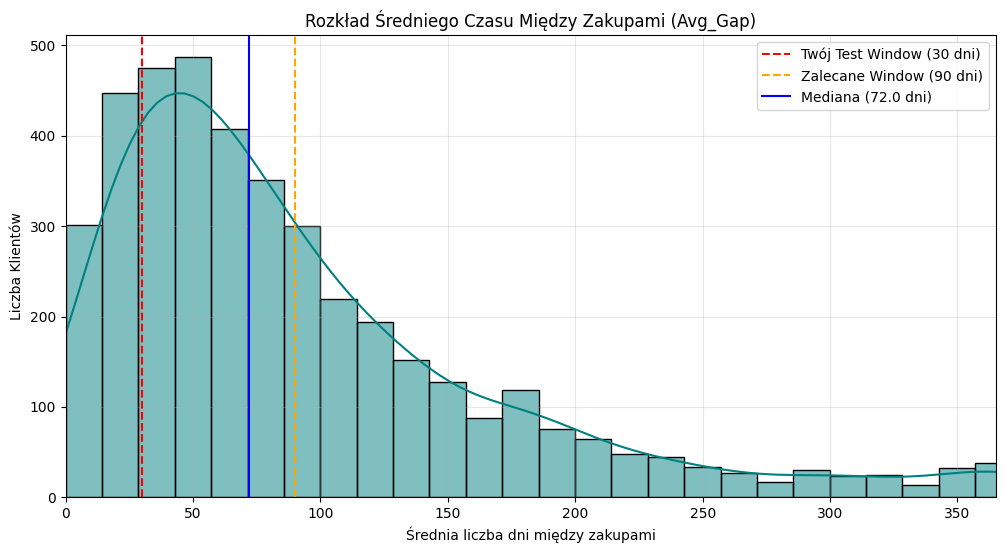

Returning Customers: 4256
Median Gap: 72.0 days
Customers with Gap > 30 days: 81.3%
Customers with Gap > 90 days: 39.6%


In [10]:
# STEP 3: Purchase Gap Analysis

try:
    # 1. Prepare Data
    # We use a clean copy and exclude returns (C-prefix) for valid gap calculation
    df_gaps = data[~data['Invoice'].astype(str).str.startswith('C')].copy()
    
    # 2. Calculate Days Between Purchases
    # Sort by customer and date, then calculate the difference
    tx_dates = df_gaps[['Customer ID', 'InvoiceDate']].drop_duplicates().sort_values(['Customer ID', 'InvoiceDate'])
    tx_dates['Days_Diff'] = tx_dates.groupby('Customer ID')['InvoiceDate'].diff().dt.days
    
    # Aggregate gaps per customer (exclude customers with only 1 purchase)
    gap_stats = tx_dates.groupby('Customer ID')['Days_Diff'].agg(['mean', 'count']).dropna()
    gap_stats.columns = ['Avg_Gap', 'Purchase_Count']

    # 3. Visualization
    plt.figure(figsize=(10, 5))
    sns.histplot(gap_stats['Avg_Gap'], bins=50, kde=True, color='teal')
    
    # Reference lines for churn thresholds
    plt.axvline(30, color='red', linestyle='--', label='30 Days (Your Window)')
    plt.axvline(90, color='orange', linestyle='--', label='90 Days (Industry Std)')
    plt.axvline(gap_stats['Avg_Gap'].median(), color='blue', label='Median Gap')
    
    plt.title('Distribution of Average Days Between Purchases')
    plt.xlabel('Days')
    plt.ylabel('Number of Customers')
    plt.xlim(0, 365) # Focus on the first year
    plt.legend()
    plt.show()

    # 4. Key Statistics Output
    print(f"Returning Customers: {len(gap_stats)}")
    print(f"Median Gap: {gap_stats['Avg_Gap'].median():.1f} days")
    print(f"Customers with Gap > 30 days: {(gap_stats['Avg_Gap'] > 30).mean():.1%}")
    print(f"Customers with Gap > 90 days: {(gap_stats['Avg_Gap'] > 90).mean():.1%}")

except Exception as e:
    print(f"Error in Gap Analysis: {e}")

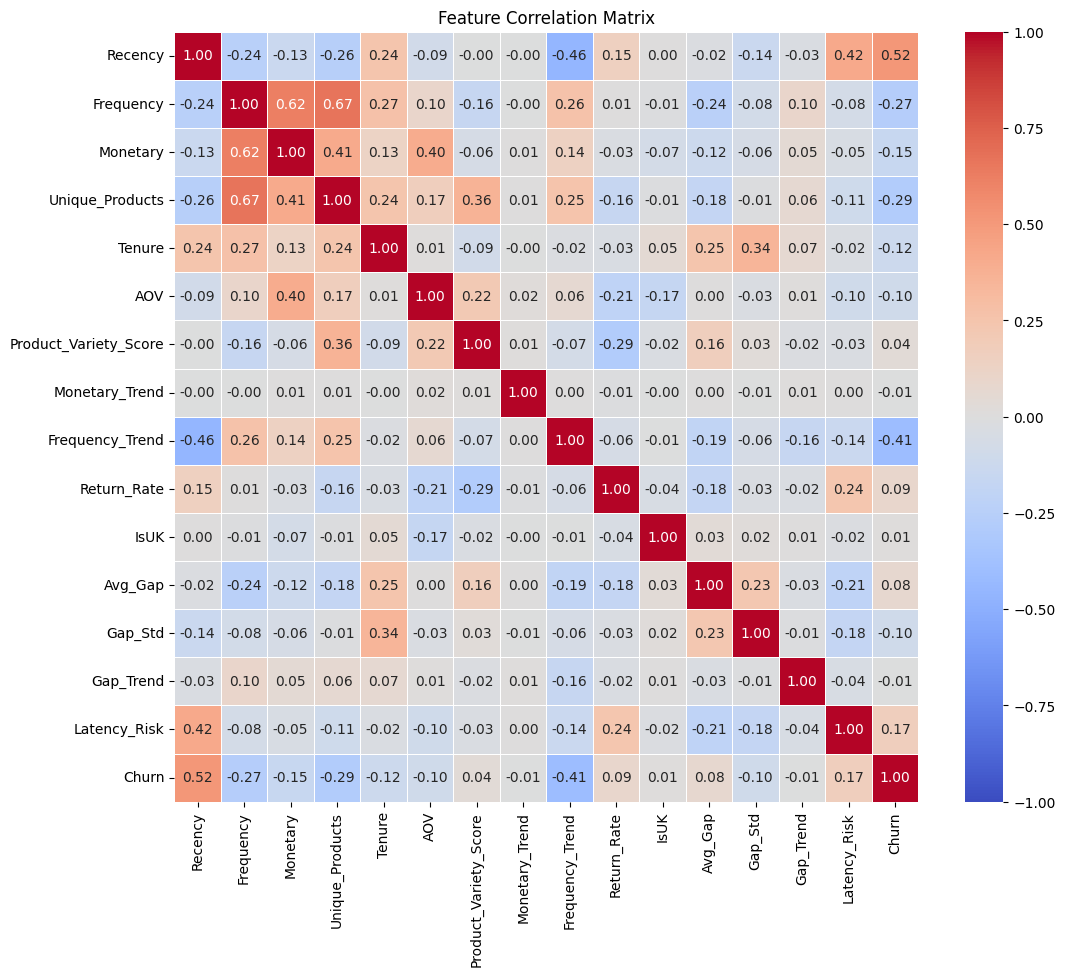


--- Feature Correlation with Churn ---
Churn                    1.000000
Recency                  0.515006
Latency_Risk             0.166140
Return_Rate              0.088120
Avg_Gap                  0.075850
Product_Variety_Score    0.035566
IsUK                     0.011918
Gap_Trend               -0.005194
Monetary_Trend          -0.007257
AOV                     -0.096260
Gap_Std                 -0.101560
Tenure                  -0.122247
Monetary                -0.151880
Frequency               -0.272183
Unique_Products         -0.287854
Frequency_Trend         -0.406885
Name: Churn, dtype: float64


In [40]:
# STEP 4: Feature Correlation Analysis

# 1. Prepare data for correlation
# Remove IDs and dates to keep only numerical features and target
cols_to_drop = ['Customer ID', 'Cutoff_Date']
corr_data = full_panel_data.drop(columns=[c for c in cols_to_drop if c in full_panel_data.columns])

# 2. Calculate Pearson correlation matrix
corr_matrix = corr_data.corr()

# 3. Visualize correlations using a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show numerical values
    fmt=".2f",        # 2 decimal places
    cmap='coolwarm',  # Red for positive, Blue for negative
    vmin=-1, vmax=1,  # Correlation scale
    linewidths=0.5
)
plt.title('Feature Correlation Matrix')
plt.show()

# 4. Rank features by correlation with Churn
print("\n--- Feature Correlation with Churn ---")
print(corr_matrix['Churn'].sort_values(ascending=False))

In [41]:
# STEP 5: Time-Series Cross-Validation

# 1. Prepare data structure
if 'Customer ID' not in full_panel_data.columns:
    full_panel_data = full_panel_data.reset_index()

# 2. Define Parameter Grid for Optimization
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

scores = []
print("Starting Expanding Window Validation...")

# 3. Walk-forward validation through cutoff dates
for i in range(1, len(cutoffs)):
    
    # Define training (past) and testing (current) sets
    train_dates = cutoffs[:i]
    test_date = cutoffs[i]
    
    train_mask = full_panel_data['Cutoff_Date'].isin(train_dates)
    test_mask  = full_panel_data['Cutoff_Date'] == test_date
    
    # Drop metadata and target for training
    X_train_curr = full_panel_data[train_mask].drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_train_curr = full_panel_data.loc[train_mask, 'Churn']
    
    X_test_curr  = full_panel_data[test_mask].drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_test_curr  = full_panel_data.loc[test_mask, 'Churn']
    
    # Run GridSearch with Inner Time-Series Split
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)   
    inner_cv = TimeSeriesSplit(n_splits=3)
    
    grid = GridSearchCV(
        clf, 
        param_grid, 
        cv=inner_cv,
        scoring='f1', 
        n_jobs=-1
    )
    grid.fit(X_train_curr, y_train_curr)
    
    # Evaluate the best model on the OOT slice
    best_model = grid.best_estimator_
    pred = best_model.predict(X_test_curr)
    score = f1_score(y_test_curr, pred)
    scores.append(score)
    
    print(f"Test Date: {test_date.date()} | Train size: {len(X_train_curr)} | F1-Score: {score:.2%}")

print("-" * 40)
print(f"Mean Stability Score (F1): {np.mean(scores):.2%}")
print("-" * 40)

Starting Expanding Window Validation...
Test Date: 2011-01-01 | Train size: 2446 | F1-Score: 73.99%
Test Date: 2011-04-01 | Train size: 5607 | F1-Score: 88.65%
Test Date: 2011-06-01 | Train size: 9009 | F1-Score: 88.98%
----------------------------------------
Mean Stability Score (F1): 83.87%
----------------------------------------


In [42]:
# STEP 6: Final Model Training (with Calibration)

# 1. Prepare Full Training Data
# Use all historical snapshots to train the final version
print("Training final model on full dataset...")
X_final = full_panel_data.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
y_final = full_panel_data['Churn']

# 2. Use Best Parameters from Step 5
# This grabs the optimized model settings automatically from your GridSearch
if 'grid' in locals():
    base_model = grid.best_estimator_
    print(f"✅ Using optimized settings: {grid.best_params_}")
else:
    # Safety fallback if Step 5 was skipped or interrupted
    print("⚠️ GridSearch not found. Using default balanced Random Forest.")
    base_model = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)

# 3. Initialize Probability Calibration
# 'isotonic' makes the model's confidence scores (probabilities) more accurate
# cv=5 ensures calibration is done via cross-validation
final_model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)

# 4. Fit Final Model
final_model.fit(X_final, y_final)

print("✅ Final Calibrated Model is trained and ready for segmentation.")

Training final model on full dataset...
✅ Using optimized settings: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 500}
✅ Final Calibrated Model is trained and ready for segmentation.


--- OUT-OF-TIME EVALUATION START ---

Generating Test Set for: 2011-11-01...
----------------------------------------
📊 OOT Results (Date: 2011-11-01)
    Accuracy: 77.59%
    Churn Rate: 72.20%
----------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.79      0.66      1171
           1       0.90      0.77      0.83      3041

    accuracy                           0.78      4212
   macro avg       0.74      0.78      0.75      4212
weighted avg       0.81      0.78      0.78      4212



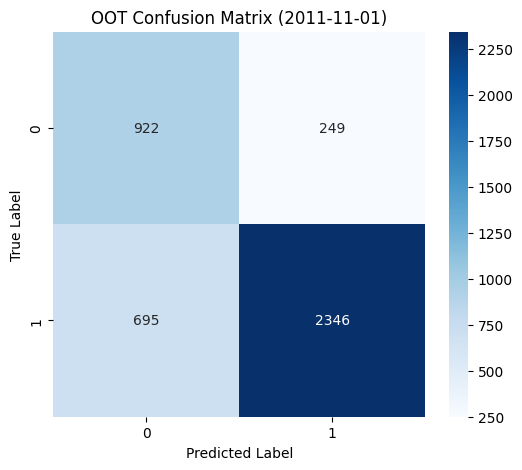

In [43]:
# STEP 7: Out-of-Time (OOT) Evaluation

print("--- OUT-OF-TIME EVALUATION START ---\n")

# 1. Generate OOT Test Set (November 2011)
test_date = pd.Timestamp('2011-11-01')
print(f"Generating Test Set for: {test_date.date()}...")

# Create features for the unseen test period
test_df = generate_features_at_cutoff(data, test_date, target_window_days=30).reset_index()

# 2. Prepare X and y
cols_to_drop = ['Churn', 'Customer ID', 'Cutoff_Date']
X_test = test_df.drop([c for c in cols_to_drop if c in test_df.columns], axis=1)
y_test = test_df['Churn']

# Clean data (handle Inf/NaN)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

# 3. Model Check & Prediction
if 'final_model' not in locals():
    print("⚠️ Model not found. Training quick fallback...")
    train_df = full_panel_data.reset_index() if 'Customer ID' not in full_panel_data.columns else full_panel_data
    X_train = train_df.drop([c for c in cols_to_drop if c in train_df.columns], axis=1).fillna(0)
    y_train = train_df['Churn']
    final_model = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced', random_state=42)
    final_model.fit(X_train, y_train)

# Get predictions and risk probabilities
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# 4. Display Performance Metrics
print("-" * 40)
print(f"📊 OOT Results (Date: {test_date.date()})")
print(f"    Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"    Churn Rate: {y_test.mean():.2%}")
print("-" * 40)
print(classification_report(y_test, y_pred))

# 5. Visualize Results (Confusion Matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'OOT Confusion Matrix ({test_date.date()})')
plt.show()

--- ADVANCED METRICS ANALYSIS ---

📊 TEST SET DIAGNOSTICS:
   Total Customers: 4212
   Total Churners (Class 1): 3041
   Actual Churn Rate (Baseline): 72.20%
------------------------------


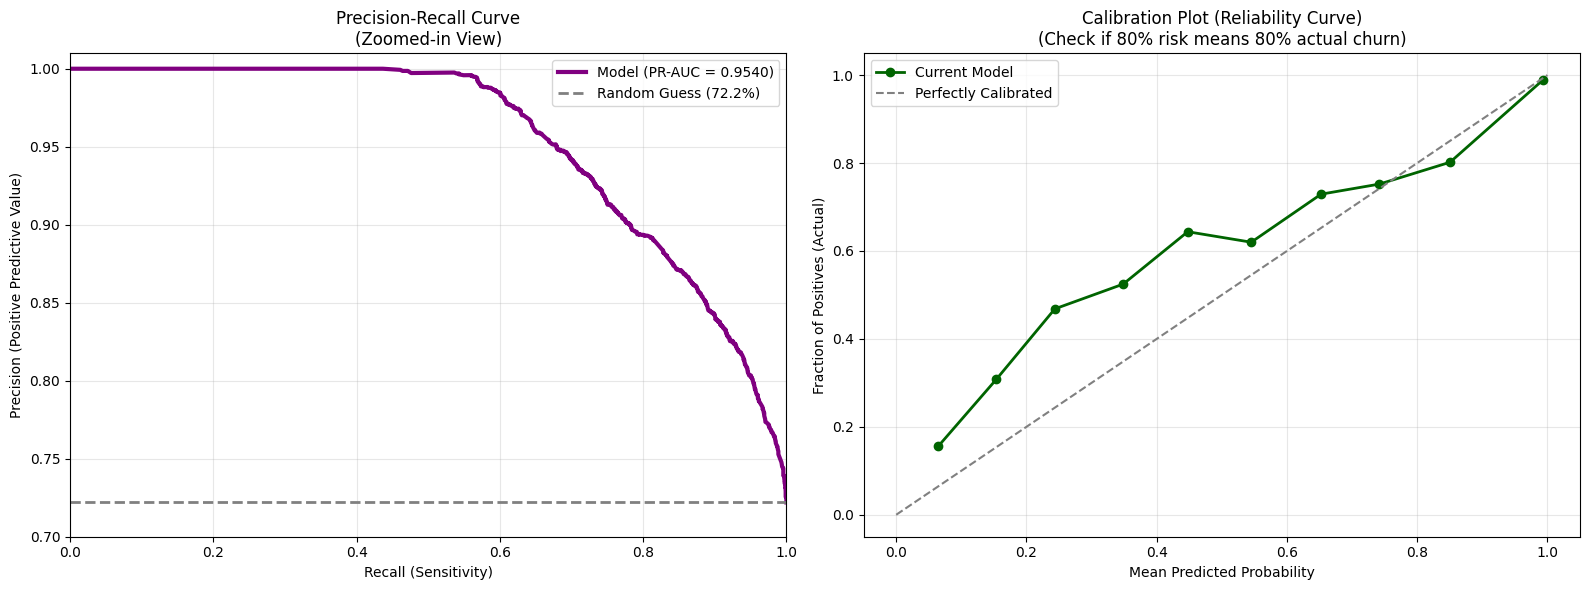

✅ Final PR-AUC: 0.9540
----------------------------------------


In [44]:
# STEP 8: Advanced Model Evaluation (PR-AUC & Calibration Plot)
print("--- ADVANCED METRICS ANALYSIS ---\n")

# 1. Dataset Diagnostics
# Calculate the actual churn rate in the test set (Baseline)
baseline_churn = y_test.mean()
print(f"📊 TEST SET DIAGNOSTICS:")
print(f"   Total Customers: {len(y_test)}")
print(f"   Total Churners (Class 1): {y_test.sum()}")
print(f"   Actual Churn Rate (Baseline): {baseline_churn:.2%}")
print("-" * 30)

# 2. Get Probabilities
# We use the calibrated model from Step 4
y_probs = final_model.predict_proba(X_test)[:, 1]

# 3. Calculate Curves
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

# Calibration Curve (Reliability Diagram)
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10, strategy='uniform')

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT PLOT: Precision-Recall Curve ---
ax1.plot(recall, precision, label=f'Model (PR-AUC = {pr_auc:.4f})', color='purple', linewidth=3)

# Random Guess Line (Horizontal line at the level of Churn Rate)
ax1.axhline(y=baseline_churn, color='gray', linestyle='--', linewidth=2, label=f'Random Guess ({baseline_churn:.1%})')

ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision (Positive Predictive Value)')
ax1.set_title('Precision-Recall Curve\n(Zoomed-in View)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1.0])
ax1.set_ylim([0.7, 1.01])

# --- RIGHT PLOT: Calibration Plot ---
ax2.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Current Model', color='darkgreen')
ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

ax2.set_xlabel('Mean Predicted Probability')
ax2.set_ylabel('Fraction of Positives (Actual)')
ax2.set_title('Calibration Plot (Reliability Curve)\n(Check if 80% risk means 80% actual churn)')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Final PR-AUC: {pr_auc:.4f}")
print("-" * 40)

--- ANALYZE FEATURE IMPORTANCE ---
Training analyzer model...


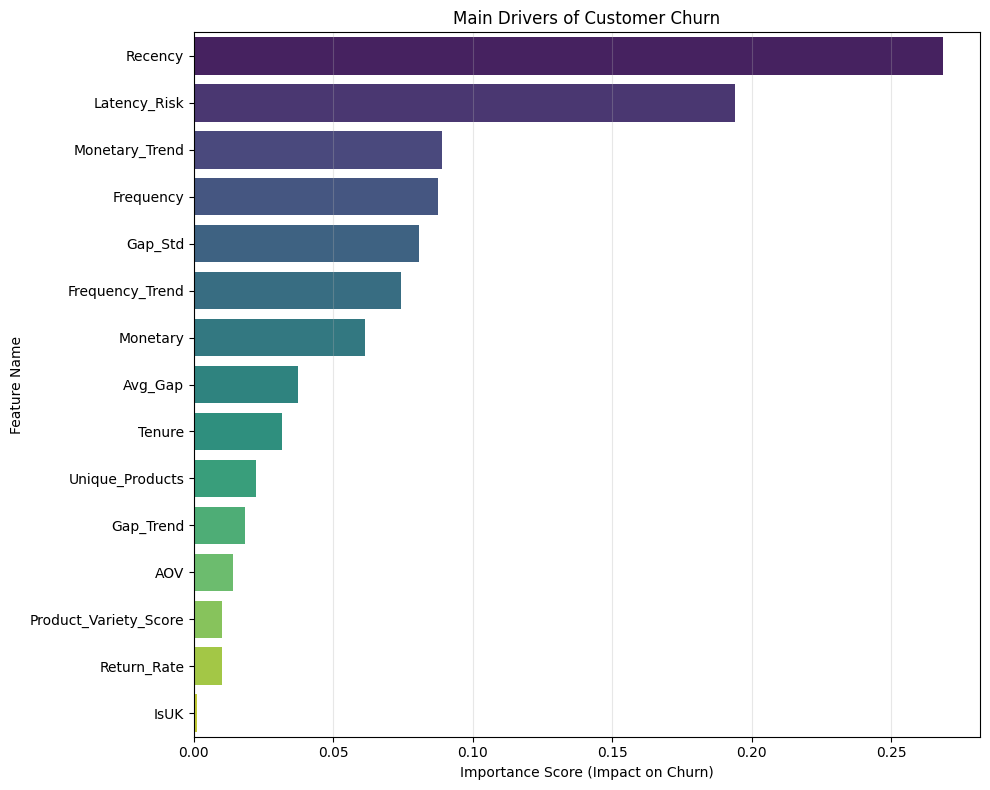


--- TOP 5 CHURN PREDICTORS ---
           Feature  Importance
0          Recency    0.268423
14    Latency_Risk    0.194032
7   Monetary_Trend    0.088999
1        Frequency    0.087612
12         Gap_Std    0.080565


In [45]:
# STEP 9: Feature Importance Analysis

print("--- ANALYZE FEATURE IMPORTANCE ---")

# 1. Prepare Data
# Ensure training data is available for analysis
if 'X_final' not in locals():
    X_final = full_panel_data.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_final = full_panel_data['Churn']

# 2. Train Analyzer Model
# We use a standard Random Forest to extract clean importance scores
print("Training analyzer model...")
analyzer_rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=8, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)
analyzer_rf.fit(X_final, y_final)

# 3. Extract Importance Scores
importances = analyzer_rf.feature_importances_
feature_names = X_final.columns

# 4. Create Importance Ranking
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5. Visualization
# Using a bar plot to show which features drive the churn prediction

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    hue='Feature',      
    data=feature_importance_df, 
    palette='viridis', 
    legend=False        
)

plt.xlabel('Importance Score (Impact on Churn)')
plt.ylabel('Feature Name')
plt.title('Main Drivers of Customer Churn')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Summary Output
print("\n--- TOP 5 CHURN PREDICTORS ---")
print(feature_importance_df.head(5))

In [46]:
# STEP 10: Segmentation with Fixed Business Rules

# 1. Get probabilities from the model
churn_probs = final_model.predict_proba(X_test)[:, 1]

# 2. Create Results Table
results = pd.DataFrame({
    'Actual_Status': y_test.values,
    'Churn_Risk': churn_probs
})
# Restore Customer ID as index
results.index = test_df['Customer ID']

# 3. Define Segments based on Rigid Rules
# These can be adjusted based on marketing capacity.
def get_segment_fixed(prob):
    # Rule 1: >80% is almost certainly churn (or already left)
    if prob >= 0.80:
        return '🔴 Critical'
    
    # Rule 2: 60-80% is our sweet spot for intervention
    elif prob >= 0.60:
        return '🟠 At Risk'
    
    # Rule 3: 40-60% is uncertain, keep an eye on them
    elif prob >= 0.40:
        return '🟡 Watchlist'
    
    # Rule 4: <40% is safe
    else:
        return '🟢 Safe'

results['Segment'] = results['Churn_Risk'].apply(get_segment_fixed)

# 4. Summary
print("\n--- FIXED SEGMENTATION SUMMARY ---")
print(results['Segment'].value_counts())

# 5. Top Candidates for Action
# We focus on the 'At Risk' group (60-80%) or Critical (>80%) depending on strategy
action_group = results[results['Segment'].isin(['🟠 At Risk', '🔴 Critical'])]
action_group = action_group.sort_values('Churn_Risk', ascending=False)

print(f"\n--- Customers requiring attention: {len(action_group)} ---")
if not action_group.empty:
    display(action_group.head(10))


--- FIXED SEGMENTATION SUMMARY ---
Segment
🔴 Critical     1904
🟢 Safe         1224
🟡 Watchlist     614
🟠 At Risk       470
Name: count, dtype: int64

--- Customers requiring attention: 2374 ---


,Actual_Status,Churn_Risk,Segment
Customer ID,,,
15258.0,1,1.0,🔴 Critical
13829.0,1,1.0,🔴 Critical
14779.0,1,1.0,🔴 Critical
13809.0,1,1.0,🔴 Critical
16646.0,1,1.0,🔴 Critical
16644.0,1,1.0,🔴 Critical
15709.0,1,1.0,🔴 Critical
16632.0,1,1.0,🔴 Critical
14777.0,1,1.0,🔴 Critical


In [47]:
# STEP 11: Financial Impact Analysis (Fixed Logic)

# 1. Prepare Financial Data
# aligning them with our prediction results
X_test_financial = test_df.set_index('Customer ID').loc[results.index].copy()

# 2. Calculate Annual Potential (Safe Extrapolation)
# Base calculation: Average Daily Spend * 365
daily_spend = X_test_financial['Monetary'] / (X_test_financial['Tenure'] + 1)
projected_annual = daily_spend * 365
X_test_financial['Annual_Potential'] = np.minimum(projected_annual, X_test_financial['Monetary'] * 3)

# 3. Merge with Segmentation Results
financial_report = results.join(X_test_financial[['Annual_Potential']], how='left')

# 4. Group by Segment
risk_report = financial_report.groupby('Segment')['Annual_Potential'].sum().sort_values(ascending=False)

# 5. Print Business Report
print("-" * 50)
print("💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)")
print("-" * 50)

for segment, amount in risk_report.items():
    print(f"{segment.ljust(35)} : £ {amount:,.2f}")

print("-" * 50)

# Calculate Total "At Risk" Value
# Summing up High Risk and Priority segments
total_risk_val = risk_report.get('🟠 At Risk', 0) + \
                 risk_report.get('🟡 Watchlist', 0)

print(f"Total Revenue requiring immediate protection: £ {total_risk_val:,.2f}")
print("-" * 50)

--------------------------------------------------
💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)
--------------------------------------------------
🟢 Safe                              : £ 6,226,505.64
🔴 Critical                          : £ 1,764,899.91
🟡 Watchlist                         : £ 1,062,035.47
🟠 At Risk                           : £ 701,853.93
--------------------------------------------------
Total Revenue requiring immediate protection: £ 1,763,889.40
--------------------------------------------------


In [14]:
import pandas as pd
import numpy as np

# ============================================================
# A) ZRÓB ZMIENNE POD MODEL (model_data, maski, X/y, grupy)
# ============================================================

# 1) Wejście: musi istnieć full_panel_data
if "full_panel_data" not in globals():
    raise NameError("Brakuje full_panel_data. Najpierw uruchom generowanie danych (concat generate_features_at_cutoff).")

model_data = full_panel_data.copy()

# 2) Ujednolicenie kolumny klienta do CustomerID
if "Customer ID" in model_data.columns:
    model_data = model_data.rename(columns={"Customer ID": "CustomerID"})
elif "CustomerID" not in model_data.columns and "index" in model_data.columns:
    model_data = model_data.rename(columns={"index": "CustomerID"})

if "CustomerID" not in model_data.columns:
    raise KeyError(f"Nie widzę kolumny klienta. Dostępne kolumny: {model_data.columns.tolist()}")

# 3) Daty i target
if "Cutoff_Date" not in model_data.columns:
    raise KeyError("Brakuje kolumny Cutoff_Date w model_data.")
model_data["Cutoff_Date"] = pd.to_datetime(model_data["Cutoff_Date"])

if "Churn" not in model_data.columns:
    raise KeyError("Brakuje kolumny Churn w model_data.")
model_data["Churn"] = model_data["Churn"].astype(int)

# 4) Feature columns
exclude_cols = {"CustomerID", "Churn", "Cutoff_Date"}
feature_cols = [c for c in model_data.columns if c not in exclude_cols]

if len(feature_cols) == 0:
    raise ValueError("feature_cols wyszło puste — sprawdź kolumny w model_data.")

# 5) Time-based split: ostatni cutoff jako TEST
all_cutoffs = sorted(model_data["Cutoff_Date"].unique())
if len(all_cutoffs) < 2:
    raise ValueError(f"Masz za mało cutoffów ({len(all_cutoffs)}). Potrzebujesz min. 2 (train+test).")

test_cutoff = all_cutoffs[-1]
train_mask = model_data["Cutoff_Date"] < test_cutoff
test_mask  = model_data["Cutoff_Date"] == test_cutoff

X_train = model_data.loc[train_mask, feature_cols]
y_train = model_data.loc[train_mask, "Churn"]
groups_train = model_data.loc[train_mask, "CustomerID"]

X_test = model_data.loc[test_mask, feature_cols]
y_test = model_data.loc[test_mask, "Churn"]

# 6) Krótki raport kontrolny
print("OK ✅ Zmienne gotowe:")
print(" - model_data:", model_data.shape)
print(" - feature_cols:", len(feature_cols))
print(" - train rows:", X_train.shape[0], "| test rows:", X_test.shape[0])
print(" - train cutoffs:", [d.date() for d in sorted(model_data.loc[train_mask, 'Cutoff_Date'].unique())])
print(" - test cutoff:", test_cutoff.date())
print(" - unique customers in train:", groups_train.nunique())


OK ✅ Zmienne gotowe:
 - model_data: (12641, 18)
 - feature_cols: 15
 - train rows: 9009 | test rows: 3632
 - train cutoffs: [datetime.date(2010, 10, 1), datetime.date(2011, 1, 1), datetime.date(2011, 4, 1)]
 - test cutoff: 2011-06-01
 - unique customers in train: 3402


In [15]:
# ============================================================
# 3) Robust evaluation setup:
#    - Outer loop: time-based validation on Cutoff_Date (future-like)
#    - Inner loop: GroupKFold by CustomerID (no customer leakage)
# ============================================================

# 3.1 Define outer folds by cutoff date (walk-forward style)
train_cutoffs = sorted(model_data.loc[train_mask, "Cutoff_Date"].unique())

# Use last 2 cutoffs as "validation candidates" inside training period (you can make it 3)
outer_val_cutoffs = train_cutoffs[-2:]   # e.g., [2011-02-01, 2011-04-01]
outer_train_cutoffs = train_cutoffs[:-2]

print("\nOuter time-based validation cutoffs:", [d.date() for d in outer_val_cutoffs])

# 3.2 KNN pipeline
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# 3.3 Production-like search space:
# - Larger k to reduce memorization (realistic generalization)
# - Prefer robust metrics only
# - algorithm/leaf_size mostly for speed (OK to keep)
param_distributions = {
    "knn__n_neighbors": randint(25, 120),            # bigger k => smoother, more stable
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["manhattan", "euclidean"],       # keep only meaningful metrics
    "knn__algorithm": ["auto", "ball_tree", "kd_tree"],
    "knn__leaf_size": randint(25, 60)
}

# Inner CV: leakage-safe by customer (within the outer train split)
inner_cv = GroupKFold(n_splits=5)

# We'll store results for each outer validation cutoff
outer_results = []

for val_cutoff in outer_val_cutoffs:
    # Outer split: train on earlier cutoffs, validate on this cutoff
    outer_train_idx = model_data.index[train_mask & (model_data["Cutoff_Date"] < val_cutoff)]
    outer_val_idx   = model_data.index[train_mask & (model_data["Cutoff_Date"] == val_cutoff)]

    X_tr = model_data.loc[outer_train_idx, feature_cols]
    y_tr = model_data.loc[outer_train_idx, "Churn"].astype(int)
    g_tr = model_data.loc[outer_train_idx, "CustomerID"]

    X_val = model_data.loc[outer_val_idx, feature_cols]
    y_val = model_data.loc[outer_val_idx, "Churn"].astype(int)

    # Random search tuned only on OUTER TRAIN part (and validated on outer val cutoff)
    search = RandomizedSearchCV(
        estimator=knn_pipeline,
        param_distributions=param_distributions,
        n_iter=30,                       # keep moderate for speed
        cv=inner_cv,
        scoring="average_precision",     # PR AUC (Average Precision) -> great when churn is dominant
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    search.fit(X_tr, y_tr, groups=g_tr)
    best_model = search.best_estimator_

    # Evaluate on outer validation cutoff (future-like)
    val_proba = best_model.predict_proba(X_val)[:, 1]
    val_ap = average_precision_score(y_val, val_proba)

    outer_results.append({
        "val_cutoff": val_cutoff,
        "best_params": search.best_params_,
        "val_PR_AUC_AP": val_ap
    })

    print(f"\n[Outer Val: {val_cutoff.date()}] PR AUC (AP) = {val_ap:.4f}")
    print("Best params:", search.best_params_)

# Summary of outer validation
outer_ap_scores = [r["val_PR_AUC_AP"] for r in outer_results]
print("\n" + "="*70)
print("✅ OUTER TIME-BASED VALIDATION SUMMARY")
print("="*70)
print("PR AUC (AP) per cutoff:", [round(s, 4) for s in outer_ap_scores])
print(f"Mean PR AUC (AP): {np.mean(outer_ap_scores):.4f} | Std: {np.std(outer_ap_scores):.4f}")

# ============================================================
# 3.4 Final training: tune on full training period, then evaluate on final test cutoff
# ============================================================

final_search = RandomizedSearchCV(
    estimator=knn_pipeline,
    param_distributions=param_distributions,
    n_iter=40,                      # a bit more for final
    cv=inner_cv,
    scoring="average_precision",    # focus purely on PR AUC as you wanted
    n_jobs=-1,
    random_state=42,
    verbose=1
)

final_search.fit(X_train, y_train, groups=groups_train)
best_knn = final_search.best_estimator_

print("\n✓ Final best params:", final_search.best_params_)
print(f"✓ Final CV PR AUC (AP): {final_search.best_score_:.4f}")


Outer time-based validation cutoffs: [datetime.date(2011, 1, 1), datetime.date(2011, 4, 1)]

[Outer Val: 2011-01-01] PR AUC (AP) = 0.9253
Best params: {'knn__algorithm': 'kd_tree', 'knn__leaf_size': 25, 'knn__metric': 'manhattan', 'knn__n_neighbors': 71, 'knn__weights': 'distance'}

[Outer Val: 2011-04-01] PR AUC (AP) = 0.9599
Best params: {'knn__algorithm': 'kd_tree', 'knn__leaf_size': 25, 'knn__metric': 'manhattan', 'knn__n_neighbors': 71, 'knn__weights': 'distance'}

✅ OUTER TIME-BASED VALIDATION SUMMARY
PR AUC (AP) per cutoff: [0.9253, 0.9599]
Mean PR AUC (AP): 0.9426 | Std: 0.0173
Fitting 5 folds for each of 40 candidates, totalling 200 fits

✓ Final best params: {'knn__algorithm': 'kd_tree', 'knn__leaf_size': 25, 'knn__metric': 'manhattan', 'knn__n_neighbors': 71, 'knn__weights': 'distance'}
✓ Final CV PR AUC (AP): 0.9329


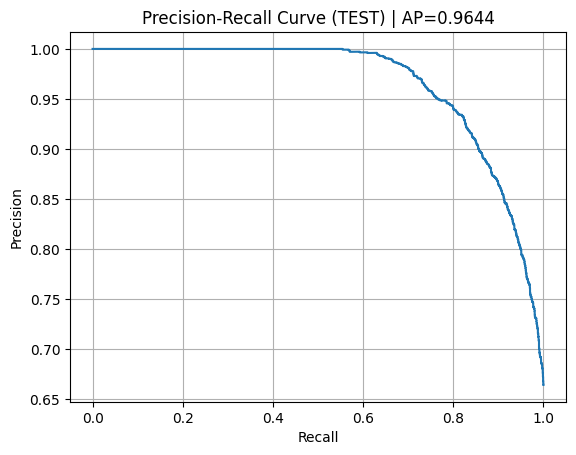

TEST Average Precision (AP): 0.9644
Best-F1 threshold: 0.5071 | Best F1 (approx): 0.8832


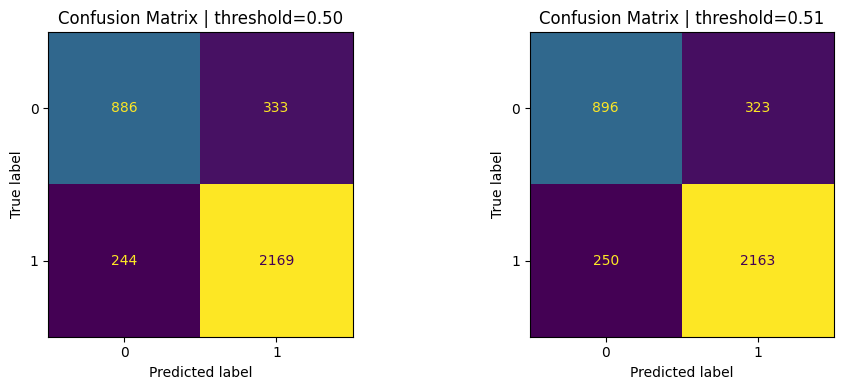

In [17]:
# ============================================================
# 4) PR Curve + Confusion Matrix (TEST cutoff) - osobny bloczek
# ============================================================

from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# --- Bezpiecznik: jeśli nie masz X_test/y_test, wylicz je na podstawie ostatniego cutoffu ---
if "X_test" not in globals() or "y_test" not in globals():
    all_cutoffs = sorted(model_data["Cutoff_Date"].unique())
    test_cutoff = all_cutoffs[-1]
    test_mask = model_data["Cutoff_Date"] == test_cutoff
    X_test = model_data.loc[test_mask, feature_cols]
    y_test = model_data.loc[test_mask, "Churn"].astype(int)

# --- Predykcje prawdopodobieństw ---
test_proba = best_knn.predict_proba(X_test)[:, 1]

# --- PR curve ---
precision, recall, thresholds = precision_recall_curve(y_test, test_proba)
ap = average_precision_score(y_test, test_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (TEST) | AP={ap:.4f}")
plt.grid(True)
plt.show()

# --- Confusion Matrix ---
# Domyślny próg 0.5 + dodatkowo próg "najlepszy F1" na PR curve (często lepszy przy churnie)
y_pred_05 = (test_proba >= 0.5).astype(int)

# Best F1 threshold (z PR curve)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_thr = thresholds[best_idx - 1] if best_idx > 0 and best_idx - 1 < len(thresholds) else 0.5
y_pred_bestf1 = (test_proba >= best_thr).astype(int)

print(f"TEST Average Precision (AP): {ap:.4f}")
print(f"Best-F1 threshold: {best_thr:.4f} | Best F1 (approx): {f1_scores[best_idx]:.4f}")

cm05 = confusion_matrix(y_test, y_pred_05)
cmb  = confusion_matrix(y_test, y_pred_bestf1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(cm05).plot(ax=axes[0], values_format="d", colorbar=False)
axes[0].set_title("Confusion Matrix | threshold=0.50")

ConfusionMatrixDisplay(cmb).plot(ax=axes[1], values_format="d", colorbar=False)
axes[1].set_title(f"Confusion Matrix | threshold={best_thr:.2f}")

plt.tight_layout()
plt.show()


Train cutoffs: [datetime.date(2010, 10, 1), datetime.date(2011, 1, 1), datetime.date(2011, 4, 1)]
Outer val cutoffs: [datetime.date(2011, 1, 1), datetime.date(2011, 4, 1)]
Test cutoff: 2011-06-01
Train rows=9009 | Test rows=3632 | Churn rate train=0.6339

[Outer Val 2011-01-01] AP=0.9257 | ROC=0.8480 | LogLoss=0.5684
Best params: {'lr__C': np.float64(62.451395747430766), 'lr__class_weight': 'balanced', 'lr__solver': 'lbfgs'}

[Outer Val 2011-04-01] AP=0.9631 | ROC=0.9169 | LogLoss=0.3473
Best params: {'lr__C': np.float64(78.52755494724258), 'lr__class_weight': None, 'lr__solver': 'lbfgs'}

✅ OUTER WALK-FORWARD SUMMARY
AP per cutoff : [0.9257, 0.9631] | mean 0.9444 std 0.0187
ROC per cutoff: [0.848, 0.9169] | mean 0.8825 std 0.0345
LL per cutoff : [0.5684, 0.3473] | mean 0.4578 std 0.1106
Fitting 5 folds for each of 60 candidates, totalling 300 fits

🏁 FINAL TEST RESULTS (latest cutoff)
Best params: {'lr__C': np.float64(78.52755494724258), 'lr__class_weight': None, 'lr__solver': 'lbfgs'

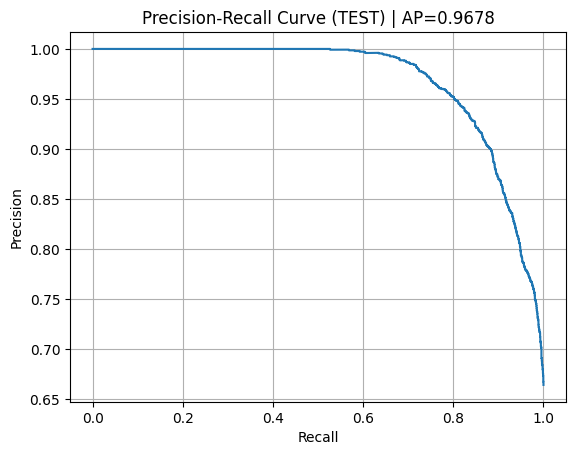


Threshold 0.50 | report:
              precision    recall  f1-score   support

           0     0.7633    0.8228    0.7919      1219
           1     0.9068    0.8711    0.8886      2413

    accuracy                         0.8549      3632
   macro avg     0.8351    0.8470    0.8403      3632
weighted avg     0.8587    0.8549    0.8562      3632

Best-F1 threshold ~ 0.4773 | approx F1=0.8917

Best-F1 threshold | report:
              precision    recall  f1-score   support

           0     0.7778    0.8039    0.7906      1219
           1     0.8992    0.8840    0.8915      2413

    accuracy                         0.8571      3632
   macro avg     0.8385    0.8439    0.8411      3632
weighted avg     0.8585    0.8571    0.8577      3632



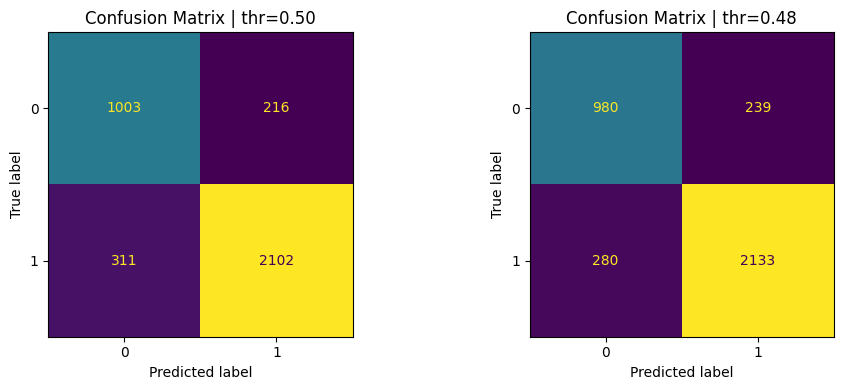


Top 20 highest churn risk (TEST cutoff):
       Customer ID Cutoff_Date  churn_proba  churn_true
10162      14244.0  2011-06-01          1.0           1
9035       12385.0  2011-06-01          1.0           1
9017       12357.0  2011-06-01          1.0           1
9023       12365.0  2011-06-01          1.0           1
10956      15546.0  2011-06-01          1.0           1
12556      18137.0  2011-06-01          1.0           1
10168      14255.0  2011-06-01          1.0           1
11820      16908.0  2011-06-01          1.0           1
9101       12496.0  2011-06-01          1.0           1
9096       12487.0  2011-06-01          1.0           1
11856      16964.0  2011-06-01          1.0           1
9375       12979.0  2011-06-01          1.0           1
11862      16978.0  2011-06-01          1.0           1
9819       13699.0  2011-06-01          1.0           1
12500      18035.0  2011-06-01          1.0           1
12507      18047.0  2011-06-01          1.0           1
12496 

In [25]:
# ============================================================
# IMPROVED LOGISTIC REGRESSION (Churn) – robust CV + calibration + thresholding
# - Outer: time-based (walk-forward on Cutoff_Date) -> future-like validation
# - Inner: GroupKFold by CustomerID -> no customer leakage during tuning
# - Tune: C, penalty/solver, class_weight (incl None), optional interactions
# - Calibrate probabilities on OUTER TRAIN only (sigmoid) -> better proba / logloss
# - Report: AP/ROC/LogLoss + PR curve + Confusion Matrix on TEST
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    average_precision_score, roc_auc_score, log_loss,
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from scipy.stats import loguniform

# -----------------------------
# 0) INPUT CHECKS + DATA PREP
# -----------------------------
if "full_panel_data" not in globals():
    raise NameError("Brakuje full_panel_data. Najpierw uruchom generowanie cech.")

TARGET = "Churn"
TIME_COL = "Cutoff_Date"

df = full_panel_data.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = df[TARGET].astype(int)

# Unify customer id column name
if "CustomerID" in df.columns:
    ID_COL = "CustomerID"
elif "Customer ID" in df.columns:
    ID_COL = "Customer ID"
elif "index" in df.columns:
    ID_COL = "index"
else:
    raise KeyError(f"Nie widzę kolumny ID klienta. Kolumny: {df.columns.tolist()}")

# Feature cols
drop_cols = {ID_COL, TIME_COL, TARGET}
feature_cols = [c for c in df.columns if c not in drop_cols]
if len(feature_cols) == 0:
    raise ValueError("feature_cols puste – sprawdź dane.")

# Sort cutoffs
all_cutoffs = sorted(df[TIME_COL].unique())
if len(all_cutoffs) < 4:
    raise ValueError(f"Za mało cutoffów ({len(all_cutoffs)}). Dla walk-forward sensownie mieć >= 4.")

test_cutoff = all_cutoffs[-1]
train_cutoffs = [c for c in all_cutoffs if c < test_cutoff]

# Use last 2 train cutoffs for outer validation (you can change to 3)
outer_val_cutoffs = train_cutoffs[-2:]
print("Train cutoffs:", [d.date() for d in train_cutoffs])
print("Outer val cutoffs:", [d.date() for d in outer_val_cutoffs])
print("Test cutoff:", test_cutoff.date())

# Final train/test split
train_mask = df[TIME_COL] < test_cutoff
test_mask  = df[TIME_COL] == test_cutoff

X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, TARGET]
g_train = df.loc[train_mask, ID_COL]

X_test = df.loc[test_mask, feature_cols]
y_test = df.loc[test_mask, TARGET]
g_test = df.loc[test_mask, ID_COL]

print(f"Train rows={X_train.shape[0]} | Test rows={X_test.shape[0]} | Churn rate train={y_train.mean():.4f}")

# -----------------------------
# 1) PIPELINE + SEARCH SPACE
# -----------------------------
# Base pipeline (scaler + LR)
base_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000))
])

# Notes:
# - We explicitly consider class_weight=None and "balanced" (balanced is NOT always good here)
# - Use solvers compatible with penalty:
#   * lbfgs -> l2
#   * liblinear -> l1/l2
param_distributions = [
    {
        "lr__solver": ["lbfgs"],
        "lr__C": loguniform(1e-2, 1e2),
        "lr__class_weight": [None, "balanced"]
    }]

inner_cv = GroupKFold(n_splits=5)

# -----------------------------
# 2) OUTER WALK-FORWARD EVAL
# -----------------------------
outer_rows = []
outer_best_params = []

for val_cutoff in outer_val_cutoffs:
    outer_train_idx = df.index[(df[TIME_COL] < val_cutoff)]          # train on earlier cutoffs
    outer_val_idx   = df.index[(df[TIME_COL] == val_cutoff)]         # validate on this cutoff

    X_tr = df.loc[outer_train_idx, feature_cols]
    y_tr = df.loc[outer_train_idx, TARGET]
    g_tr = df.loc[outer_train_idx, ID_COL]

    X_val = df.loc[outer_val_idx, feature_cols]
    y_val = df.loc[outer_val_idx, TARGET]

    if g_tr.nunique() < 5:
        raise ValueError(f"Za mało klientów ({g_tr.nunique()}) w outer-train dla {val_cutoff.date()}")

    search = RandomizedSearchCV(
        estimator=base_pipe,
        param_distributions=param_distributions,
        n_iter=40,
        cv=inner_cv,
        scoring="average_precision",      # focus on PR-AUC(AP) for churn ranking
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X_tr, y_tr, groups=g_tr)
    best_pipe = search.best_estimator_

    # Optional: calibrate probabilities using ONLY outer-train (no leakage)
    # We calibrate the WHOLE pipeline (scaler+lr) with inner CV on outer-train.
    cal_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cal = CalibratedClassifierCV(best_pipe, method="sigmoid", cv=cal_cv)
    cal.fit(X_tr, y_tr)


    val_proba = cal.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, val_proba)
    roc = roc_auc_score(y_val, val_proba)
    ll = log_loss(y_val, val_proba)

    outer_rows.append((val_cutoff.date(), ap, roc, ll))
    outer_best_params.append(search.best_params_)

    print(f"\n[Outer Val {val_cutoff.date()}] AP={ap:.4f} | ROC={roc:.4f} | LogLoss={ll:.4f}")
    print("Best params:", search.best_params_)

aps = [r[1] for r in outer_rows]
rocs = [r[2] for r in outer_rows]
lls = [r[3] for r in outer_rows]

print("\n" + "="*70)
print("✅ OUTER WALK-FORWARD SUMMARY")
print("="*70)
print("AP per cutoff :", [round(x, 4) for x in aps],  "| mean", round(float(np.mean(aps)), 4),  "std", round(float(np.std(aps)), 4))
print("ROC per cutoff:", [round(x, 4) for x in rocs], "| mean", round(float(np.mean(rocs)), 4), "std", round(float(np.std(rocs)), 4))
print("LL per cutoff :", [round(x, 4) for x in lls],  "| mean", round(float(np.mean(lls)), 4),  "std", round(float(np.std(lls)), 4))

# -----------------------------
# 3) FINAL TRAINING ON FULL TRAIN, CALIBRATE, TEST
# -----------------------------
final_search = RandomizedSearchCV(
    estimator=base_pipe,
    param_distributions=param_distributions,
    n_iter=60,
    cv=inner_cv,
    scoring="average_precision",
    n_jobs=-1,
    random_state=42,
    verbose=1
)
final_search.fit(X_train, y_train, groups=g_train)
best_lr_pipe = final_search.best_estimator_

# Calibrate on FULL TRAIN only (leakage-safe)
cal_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_lr_cal = CalibratedClassifierCV(best_lr_pipe, method="sigmoid", cv=cal_cv)
best_lr_cal.fit(X_train, y_train)

test_proba = best_lr_cal.predict_proba(X_test)[:, 1]
test_ap = average_precision_score(y_test, test_proba)
test_roc = roc_auc_score(y_test, test_proba)
test_ll = log_loss(y_test, test_proba)

print("\n" + "="*70)
print("🏁 FINAL TEST RESULTS (latest cutoff)")
print("="*70)
print("Best params:", final_search.best_params_)
print(f"TEST AP  : {test_ap:.4f}")
print(f"TEST ROC : {test_roc:.4f}")
print(f"TEST LL  : {test_ll:.4f}")

# -----------------------------
# 4) PR CURVE + THRESHOLDING + CONFUSION MATRICES
# -----------------------------
precision, recall, thresholds = precision_recall_curve(y_test, test_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (TEST) | AP={test_ap:.4f}")
plt.grid(True)
plt.show()

# default threshold
thr_05 = 0.5
y_pred_05 = (test_proba >= thr_05).astype(int)

# best-F1 threshold on PR curve (optional)
f1 = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1))
best_thr = thresholds[best_idx - 1] if 0 < best_idx <= len(thresholds) else 0.5
y_pred_best = (test_proba >= best_thr).astype(int)

print(f"\nThreshold 0.50 | report:")
print(classification_report(y_test, y_pred_05, digits=4))
print(f"Best-F1 threshold ~ {best_thr:.4f} | approx F1={f1[best_idx]:.4f}")
print("\nBest-F1 threshold | report:")
print(classification_report(y_test, y_pred_best, digits=4))

cm05 = confusion_matrix(y_test, y_pred_05)
cmb  = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm05).plot(ax=axes[0], values_format="d", colorbar=False)
axes[0].set_title("Confusion Matrix | thr=0.50")
ConfusionMatrixDisplay(cmb).plot(ax=axes[1], values_format="d", colorbar=False)
axes[1].set_title(f"Confusion Matrix | thr={best_thr:.2f}")
plt.tight_layout()
plt.show()

# -----------------------------
# 5) TOP RISK CUSTOMERS (TEST)
# -----------------------------
pred_out = df.loc[test_mask, [ID_COL, TIME_COL]].copy()
pred_out["churn_proba"] = test_proba
pred_out["churn_true"] = y_test.values
pred_out = pred_out.sort_values("churn_proba", ascending=False)

print("\nTop 20 highest churn risk (TEST cutoff):")
print(pred_out.head(20))
